

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [4]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [5]:
#PLEASE RUN THIS CELL 
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import random


from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Using TensorFlow backend.


In [6]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
import random
from tqdm import tqdm_notebook
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from random import randint
from imgaug import augmenters
from keras.layers import *
from keras.metrics import *
import sys
import glob
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
import tensorflow as tf
from skimage.transform import rescale, resize, downscale_local_mean
import time
from keras.callbacks import ModelCheckpoint
import skimage

In [7]:
from tensorflow import keras
keras.backend.clear_session()
K.clear_session()

## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

In [34]:
df_attr_celeba = pd.read_csv("list_attr_celeba.csv")
df_attr_celeba.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
datagen=ImageDataGenerator(rescale=1./255)
data_generator=datagen.flow_from_dataframe(dataframe=df_attr_celeba, directory="celeb_data/img_align_celeba",
                                            x_col="image_id",  class_mode=None,
                                            target_size=(218,178), batch_size=2048)

Found 0 images.


In [7]:
data_generator.image_shape, df_attr_celeba.shape

((218, 178, 3), (202599, 41))

In [8]:
df_attr_celeba.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [9]:
df_attr_celeba.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# function to generate a random number
def random_with_N_digits(n):
    range_start = 1**(n)
    range_end = 202599
    num = randint(range_start, range_end)
    image_num = '{:06}'.format(num)
    return image_num

In [11]:
lst = [random_with_N_digits(6) + '.jpg' for i in range(3)]   #store the image id of 3 random images in a list

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
108942,108943.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
13202,013203.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,1,-1,-1,-1,-1


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
74793,074794.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


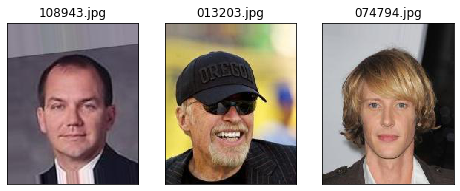

In [13]:
# plot 3 random images generated

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,10))
axs=[ax1,ax2,ax3]

for i in range(3):
    image_path = 'celeba_data/img_align_celeba/' + lst[i]   # plotting random image from celeb_data set of images
    img = plt.imread(image_path)
    axs[i].imshow(img)   #print the random image selected
    axs[i].axes.get_yaxis().set_visible(False)
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].set_title(lst[i])
    
    display(df_attr_celeba.iloc[np.where(df_attr_celeba['image_id'] == lst[i])]) #print attributes of same image from dataframe

Three random images are selected and plotted, I noticed that some images match perfectly with feature values while data for remaining images are not matched well

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celebA dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

#### Please note that the VAE model can take a long time to train before you obtain decent results. Expect to train for more than 2-3hrs depending on the batch size

In [14]:
# checking on the size of the original image
sample_img = plt.imread('celeba_data/img_align_celeba/000001.jpg')
sample_img.shape

(218, 178, 3)

In [15]:
# hyperparameters
height = sample_img.shape[0]
width = sample_img.shape[1]
latent_dim = 2
batch_size_vae = 32

# Input Layer
input_layer = Input(shape=(height, width, 3))

In [16]:
######  FLOW_FROM_DIRECTORY

## Image Data Generator to load images into train and validation data iterators in batches

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(directory="40000_data/", class_mode="input",
                                            target_size=(height, width), batch_size=batch_size_vae, subset = 'training')


## Used around 20% of the data for training

Found 96 images belonging to 1 classes.


In [14]:
## Image Data Generator to load images into train and validation data iterators in batches

datagen = ImageDataGenerator(rescale=1./255, validation_split= .10)
train_generator = datagen.flow_from_directory(directory="celeb_data/", class_mode="input",
                                            target_size=(218, 178), batch_size=32, subset = 'training')
val_generator = datagen.flow_from_directory(directory="celeb_data/", class_mode="input",
                                            target_size=(218, 178), batch_size=32, subset = 'validation')

Found 182340 images belonging to 1 classes.
Found 20259 images belonging to 1 classes.


In [17]:
## Consolidating the batches of images into a single numpy.ndarray
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [18]:
# Define the sampling function
def sampling(args):
    """Samples latent variable from a normal distribution using the given parameters."""
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size_vae, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Define val loss function with KL divergence
def vae_loss(y_true, y_pred):
    """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
    recon_loss = K.mean(keras.losses.mean_squared_error(y_true, y_pred), axis=(1,2))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return tf.reduce_mean(recon_loss + kl_loss)

In [19]:
#  NEW
################# ENCODER ##############


input_layer = Input(shape=(height, width, 3))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
encoded_layer4 = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
encoded_layer5 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer4)
encoded_layer6 = MaxPool2D( (2, 2), padding='same')(encoded_layer5)

_, *shape_spatial = encoded_layer6.get_shape().as_list()
encoded_layer6_flat = Flatten()(encoded_layer6)

# define parameters
z_mean = Dense(latent_dim, name="mean")(encoded_layer6_flat)
z_log_sigma = Dense(latent_dim, name="log_sigma")(encoded_layer6_flat)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

# Encoder model and summary
encoder_with_sampling = Model(input = input_layer, output = z)
encoder_with_sampling.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 218, 178, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 109, 89, 64)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 109, 89, 32)  18464       max_pooling2d_1[0][0]            
_____________________________________

In [27]:
# decoding architecture -----NEW

################# DECODER ##############

inputs_embedding = Input((2,), name="inputdecoder")
embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
embedding = Reshape(encoded_layer6.shape.as_list()[1:])(embedding)

decoded_layer1 = UpSampling2D((2, 2))(embedding)
decoded_layer2 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer4 = Conv2D(32, (3, 3), activation='relu')(decoded_layer3)
decoded_layer5 = UpSampling2D((2, 2))(decoded_layer4)
decoded_layer4 = Conv2D(32, (3, 3), activation='relu')(decoded_layer3)
output_layer  = Conv2D(3, (3, 3), activation='relu')(decoded_layer5)

# Decoder model and summary
decoder = Model(input = inputs_embedding, output = output_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputdecoder (InputLayer)    (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10304)             30912     
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 23, 16)        0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 56, 46, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 46, 16)        2320      
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 112, 92, 16)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 110, 90, 32)       4640      
__________

In [28]:
# Define the models.
decoder = Model(input = inputs_embedding, output = output_layer)
encoder_with_sampling = Model(input = input_layer, output = z)

# VAE model and Summary
vae_out = decoder(encoder_with_sampling(input_layer))
vae = Model(input = input_layer, output = vae_out)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 218, 178, 3)       0         
_________________________________________________________________
model_10 (Model)             (None, 2)                 66100     
_________________________________________________________________
model_9 (Model)              (None, 218, 178, 3)       38739     
Total params: 104,839
Trainable params: 104,839
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Adam optimizer and VAE Compile model
# adam1 = Adam(lr=0.0002, beta_1=0.5)
vae.compile(loss=vae_loss, optimizer='adam')

In [30]:
model_checkpoint = ModelCheckpoint(filepath='training_checkpoints_VAE.hdf5',
                     verbose = 0,
                     monitor = 'val_loss',
                     save_best_only=True,
                     save_weights_only=True,
                     mode='max',
                     period=5)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

**compile and run the model**

In [24]:
model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=10,
                    validation_data=val_generator, validation_steps=STEP_SIZE_VALID,
                   callbacks=[early_stopping]) # fit the model for the image data generator way of loading images

Epoch 1/10
5698/5698 [==============================] - 1216s 213ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 2/10
5698/5698 [==============================] - 1206s 212ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/10
5698/5698 [==============================] - 1204s 211ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/10
5698/5698 [==============================] - 1204s 211ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/10
5698/5698 [==============================] - 1204s 211ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/10
5698/5698 [==============================] - 1208s 212ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/10
5698/5698 [==============================] - 1208s 212ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/10
5698/5698 [==============================] - 1207s 212ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/10
5698/5698 [==============================] - 1201s 211ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/10
5698/5698 [==============

In [ ]:
vae.save('training_checkpoints_VAE/vae_model.h5')

In [ ]:
new_vae = load_model('training_checkpoints_VAE/vae_model.h5')
new_vae.summary()
vae.fit_generator(train_generator, steps_per_epoch=5, epochs=10, verbose=1,
#                  validation_data=val_generator, validation_steps=200,
                  callbacks=[early_stopping])

In [ ]:
def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

In [ ]:
save_weights('training_checkpoints_VAE')
load_weights('training_checkpoints_VAE')

<h5> solution to 1b3 </h5>

In [32]:
# Select a random image to verify the encoder and decoder
rand_img = random_with_N_digits(6) + '.jpg'  # generate a random number
path = 'celeb_data/img_align_celeba/' + rand_img   # append '.jpg'  extension

# pass the random image via encoder and decoder and then plot the image
img = plt.imread(path)
if img.shape[0] != height or img.shape[1] != width:
    img = skimage.transform.resize(img, (height, width))   # skimage resize does the normalization part
img_single = np.expand_dims(img, axis=0)
img_single = np.repeat(img_single, batch_size_vae, axis=0)

print(img_single.shape)

celeb_data/img_align_celeba/137019.jpg
(32, 218, 178, 3)


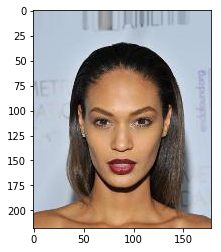

In [32]:
#Read and plot the original image

img_read = plt.imread(path)
plt.imshow(img_read)

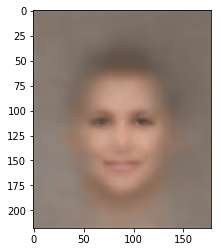

In [63]:
## Use VAE to predict the image 

res2 = vae.predict(img_single)  # predict on the image
#plot the predicted image  on VAE
plt.imshow(res2[0])

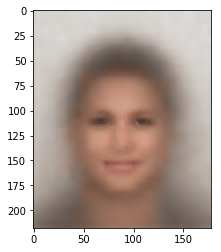

In [35]:
#plot the predicted image
plt.imshow(res[0])

**Solution to 1.B.4**

In [53]:
datagen=ImageDataGenerator(rescale=1./255)
grid_generator=datagen.flow_from_dataframe(dataframe=df_attr_celeba, directory="celeba_data/img_align_celeba",
                                            x_col="image_id",  class_mode=None,
                                            target_size=(105,87), batch_size=batch_size_vae)

Found 202599 images.


In [16]:
df_attr_celeba.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
dd = {}
selected_conditionals = list(df_attr_celeba.iloc[1:])
for i, row in df_attr_celeba.iterrows():
    dd[i] = [int(row[c]) for c in selected_conditionals]

In [2]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [3]:
def decode_embedding(z, conditioning, decoder):
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0) # Single-batch
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

In [ ]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
init_meta = dd[file_id]
img = skimage.io.imread(rnd_file)
plt.imshow(img)
plt.show()

In [ ]:
z = encode_image(img.astype(np.float32) / 255., np.array(init_meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

In [ ]:
ret = decode_embedding(z, init_meta, decoder)
plt.imshow(ret[0])
plt.show()

In [ ]:
dim1 = 'Male' # you can change these to other attributes such as No_Beard or Young
dim2 = 'Smiling'
base_vec = np.array(list(z[0]) + meta)
rendering, _ = utils.display_manifold(
    decoder, 
    HEIGHT, 
    WIDTH, 
    base_vec, 
    bound_x=15, 
    bound_y=15, 
    axis_x=LATENT_DIM + selected_conditionals.index(dim1), 
    axis_y=LATENT_DIM + selected_conditionals.index(dim2), 
    n=10,
    desc_x = dim1,
    desc_y = dim2,
    file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png')

### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs

In [38]:
# Define variables of use
adam1 = Adam(lr=0.0002, beta_1=0.5)   # Kernel Optimizer
num_filters = 8
z_dim = 100
batch_size_gan = 32
height = 28
width = 28
# height = 28
# width = 28

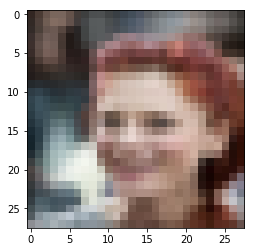

In [8]:
# Resize original image to almost 25% of the original size
# Rational for smaller image size in GAN: if the img size is large, it will be too difficult for the generator 
# to create a very realistic image that fools the discriminator. In such a case, the discriminator is too good 
# while the generator is too bad, and the latter won't be able to catch up with the former

sample_img = plt.imread('celeba_data/img_align_celeba/000002.jpg')
image_resized = resize(sample_img, (28, 28), anti_aliasing=True)
plt.imshow(image_resized)

In [40]:
#GENERATOR - NEW --- keep

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*128, input_shape=[z_dim, ]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name="lrinputg"))
    model.add(Reshape((7, 7, 128)))    
    
#     model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', name="g1Conv"))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.2, name="lr1g"))
        
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', name="g2Conv"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name="lr2g"))
    
    model.add(Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', name="g3Conv"))
    return model

generator = make_generator_model()
generator.summary()
generator.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
lrinputg (LeakyReLU)         (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
g2Conv (Conv2DTranspose)     (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
lr2g (LeakyReLU)             (None, 14, 14, 64)        0         
__________

In [41]:
# DISCRIMINATOR

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', name="d1Conv", input_shape=[28, 28, 3]))
    model.add(LeakyReLU(alpha=0.2, name="lr1d"))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', name="d2Conv"))
    model.add(LeakyReLU(alpha=0.2, name="lr2d"))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', name="d3Conv"))
    model.add(LeakyReLU(alpha=0.2, name="lr3d"))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=adam1, metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1Conv (Conv2D)              (None, 14, 14, 64)        4864      
_________________________________________________________________
lr1d (LeakyReLU)             (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
d2Conv (Conv2D)              (None, 7, 7, 128)         204928    
_________________________________________________________________
lr2d (LeakyReLU)             (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
___________________________

In [42]:
#GAN
discriminator.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = generator(inputs)
output = discriminator(hidden)
gan = Model(inputs, output)
gan.summary()
gan.compile(loss='binary_crossentropy', optimizer=adam1, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 3)         868483    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 415681    
Total params: 1,284,164
Trainable params: 855,811
Non-trainable params: 428,353
_________________________________________________________________


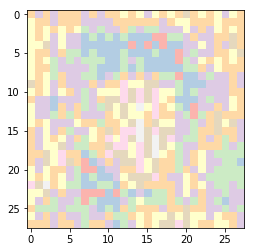

In [42]:
### Generate random noise and pass that as input to the generator
### Output of generator is a batch of generated images which is then passed onto the discriminator.
### Below is a plot of 1 single generated image

noise = np.random.normal(0, 1, size=(batch_size_gan, z_dim))
generated_images = generator.predict(noise)
generated_images = generated_images.astype('float32')/255
plt.imshow(generated_images[0, :, :, 2], cmap='Pastel1')

In [43]:
###### Passing generator output to the discriminator. It outputs a vector of size (batch_size, 1)
# output of discriminator is a decision of whether image is real or fake

decision = discriminator.predict(generated_images)
print("Precision is ", decision[0])

Precision is  [0.5000244]


In [49]:
# Entire Dataset
datagen = ImageDataGenerator(rescale=1./255)
GAN_data_generator = datagen.flow_from_directory(directory="celeba_data/", class_mode=None,
                                            target_size=(height, width), batch_size=batch_size_gan)

Found 202599 images belonging to 1 classes.


In [10]:
### images for sampling
datagen = ImageDataGenerator(rescale=1./255)
GAN_data_generator = datagen.flow_from_directory(directory="45000_data/", class_mode=None,
                                            target_size=(height, width), batch_size=batch_size_gan)

# used around 20% of the data

Found 45000 images belonging to 1 classes.


In [88]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Plot of discriminator vs generator loss')
    plt.legend()
    plt.show()

In [61]:
# def plot_generated(e, n_ex=10, dim=(1, 10), figsize=(12, 2)):
def plot_generated(epoch):
    n_ex = 10
    dim=(1, 10)
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.astype('float32')/255    
#     generated_images = resize(generated_images, (5, 5), anti_aliasing=True)

    plt.figure(figsize=(12, 2))
    for i in range(dim[1]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 2], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.title('Plot of PNG images')
    plt.savefig('GAN_output_images_gif/ImageHeigt_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [64]:
losses = {"D":[], "G":[]}
z_dim = 100


def train(epochs=1, plt_frq=1, BATCH_SIZE=batch_size_gan):
#     batchCount = int(X_train.shape[0] / BATCH_SIZE)
    batchCount = GAN_data_generator.n//GAN_data_generator.batch_size
    
    g_loss = 0.0
    d_loss = 0.0
    
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            start = time.time()
            
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            
            # Create a batch by drawing random index numbers from the training set
            image_batch = next(GAN_data_generator)
            
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Generate the images from the noise
            generated_images = generator.predict(noise)
            
            X = np.concatenate((image_batch, generated_images))

            # Create labels
            y = np.zeros(len(X))
            half = np.uint8(len(X)*0.5)
            y[:half] = 0.9  # label smoothing for fake images
            
            # Train discriminator on generated images
            discriminator.trainable = True
#             d_loss2 = discriminator.train_on_batch(X, y)
#             d_loss3 = discriminator.train_on_batch(X, y)
            d_loss = discriminator.train_on_batch(X, y)
                
                
            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
#             g_loss2 = gan.train_on_batch(noise, y2)
#             g_loss = gan.train_on_batch(noise, y2)
            
        
        # Only store losses from final
        losses["G"].append(g_loss)
        losses["D"].append(d_loss)
        print("G/D loss:", g_loss, d_loss)
        
        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated(e)
            # Produce images for the PNG as we go
            #display.clear_output(wait=True)
            print ('Time for epoch {} is {:.2f} min'.format(e, (time.time()-start)/60))  # time for each epoch
#             generate_and_save_images(generator, e , noise)
    plot_loss(losses)

Epochs: 300
Batch size: 32
Batches per epoch: 3


G/D loss: [0.74765205, 0.34375] [0.69497836, 0.390625]


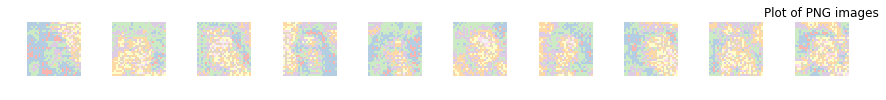

Time for epoch 1 is 0.02 min
G/D loss: [0.7840608, 0.25] [0.7047047, 0.296875]
G/D loss: [0.77082664, 0.25] [0.6959267, 0.40625]
G/D loss: [0.8092043, 0.0] [0.6942124, 0.390625]
G/D loss: [0.85783714, 0.09375] [0.6701069, 0.421875]
G/D loss: [0.7910191, 0.15625] [0.69271433, 0.421875]
G/D loss: [0.7966525, 0.03125] [0.69199026, 0.4375]
G/D loss: [0.7961794, 0.125] [0.68040097, 0.453125]
G/D loss: [0.8655845, 0.03125] [0.6739183, 0.453125]
G/D loss: [0.8621242, 0.03125] [0.67428327, 0.5]
G/D loss: [0.79543006, 0.0625] [0.68025374, 0.4375]
G/D loss: [0.81707084, 0.09375] [0.6853224, 0.375]
G/D loss: [0.84735763, 0.03125] [0.6688919, 0.484375]
G/D loss: [0.8295358, 0.03125] [0.67255723, 0.484375]
G/D loss: [0.79809654, 0.03125] [0.7028458, 0.4375]
G/D loss: [0.8670721, 0.0] [0.6901543, 0.484375]
G/D loss: [0.8579232, 0.0] [0.67769885, 0.484375]
G/D loss: [0.8590031, 0.03125] [0.71827483, 0.46875]
G/D loss: [0.82434744, 0.0] [0.6791588, 0.5]
G/D loss: [0.8255254, 0.0] [0.67032874, 0.5]
G/D

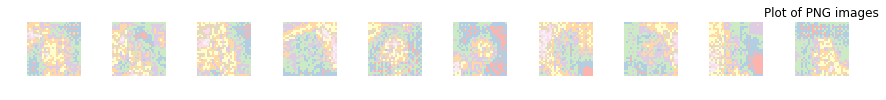

Time for epoch 30 is 0.03 min
G/D loss: [0.85506546, 0.0625] [0.68869144, 0.46875]
G/D loss: [0.81683064, 0.0625] [0.68892163, 0.5]
G/D loss: [0.74012816, 0.25] [0.68634117, 0.453125]
G/D loss: [0.7327082, 0.375] [0.678716, 0.453125]
G/D loss: [0.717304, 0.34375] [0.6568919, 0.453125]
G/D loss: [0.73975277, 0.1875] [0.66142577, 0.46875]
G/D loss: [0.7804518, 0.09375] [0.65404123, 0.5]
G/D loss: [0.69654405, 0.4375] [0.6562613, 0.5]
G/D loss: [0.7307563, 0.28125] [0.66374195, 0.453125]
G/D loss: [0.7513881, 0.25] [0.70003027, 0.359375]
G/D loss: [0.82023, 0.03125] [0.6769175, 0.375]
G/D loss: [0.908596, 0.0] [0.6851001, 0.453125]
G/D loss: [0.90878594, 0.03125] [0.6813464, 0.46875]
G/D loss: [0.8964445, 0.125] [0.6559027, 0.453125]
G/D loss: [0.95459163, 0.1875] [0.64108, 0.484375]
G/D loss: [0.82121015, 0.25] [0.6690113, 0.4375]
G/D loss: [0.79650414, 0.4375] [0.67725074, 0.46875]
G/D loss: [0.81438243, 0.21875] [0.6882051, 0.46875]
G/D loss: [0.76695395, 0.25] [0.6945447, 0.46875]
G/D

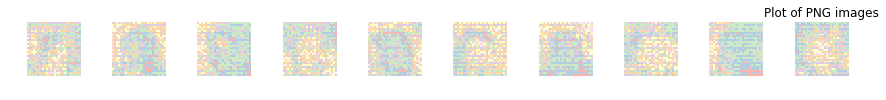

Time for epoch 60 is 0.02 min
G/D loss: [0.84239495, 0.03125] [0.6799592, 0.4375]
G/D loss: [0.8343125, 0.125] [0.67744553, 0.40625]
G/D loss: [0.8497038, 0.125] [0.6376494, 0.453125]
G/D loss: [0.8342469, 0.1875] [0.6648857, 0.34375]
G/D loss: [0.8452256, 0.34375] [0.6305729, 0.4375]
G/D loss: [0.8045732, 0.25] [0.69433796, 0.390625]
G/D loss: [0.8212652, 0.28125] [0.747293, 0.328125]
G/D loss: [0.98141724, 0.125] [0.71975565, 0.453125]
G/D loss: [1.1700542, 0.09375] [0.6502313, 0.4375]
G/D loss: [0.82709646, 0.25] [0.61543614, 0.484375]
G/D loss: [0.61968243, 0.78125] [0.6865117, 0.171875]
G/D loss: [0.7110197, 0.46875] [0.7006978, 0.375]
G/D loss: [0.74526167, 0.21875] [0.71757543, 0.21875]
G/D loss: [0.8372992, 0.0] [0.68692565, 0.46875]
G/D loss: [0.87791467, 0.0] [0.66754574, 0.484375]
G/D loss: [0.89132845, 0.0] [0.6988556, 0.5]
G/D loss: [0.86321545, 0.03125] [0.6832947, 0.484375]
G/D loss: [0.89218944, 0.03125] [0.65929484, 0.453125]
G/D loss: [0.90038425, 0.09375] [0.6640201,

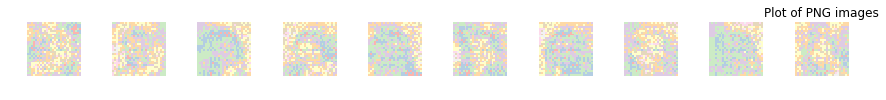

Time for epoch 90 is 0.02 min
G/D loss: [0.88142765, 0.125] [0.6863582, 0.4375]
G/D loss: [0.74031615, 0.53125] [0.64539814, 0.359375]
G/D loss: [0.9482969, 0.03125] [0.7124062, 0.421875]
G/D loss: [1.0005803, 0.15625] [0.68726623, 0.421875]
G/D loss: [0.9071518, 0.0625] [0.6816781, 0.484375]
G/D loss: [0.9400371, 0.0] [0.669246, 0.5]
G/D loss: [0.94253993, 0.03125] [0.675805, 0.5]
G/D loss: [0.91614044, 0.0625] [0.6808864, 0.484375]
G/D loss: [0.847335, 0.125] [0.66500753, 0.484375]
G/D loss: [0.9070496, 0.03125] [0.67161393, 0.484375]
G/D loss: [0.85798377, 0.03125] [0.6727328, 0.4375]
G/D loss: [0.9050513, 0.03125] [0.6745595, 0.46875]
G/D loss: [0.83832633, 0.09375] [0.730127, 0.359375]
G/D loss: [0.8831769, 0.125] [0.73625004, 0.359375]
G/D loss: [0.87064195, 0.03125] [0.71248317, 0.375]
G/D loss: [0.96120876, 0.0] [0.65006405, 0.484375]
G/D loss: [1.0193467, 0.0] [0.6702057, 0.5]
G/D loss: [0.9132023, 0.09375] [0.6571993, 0.5]
G/D loss: [0.86942697, 0.25] [0.68429005, 0.421875]
G

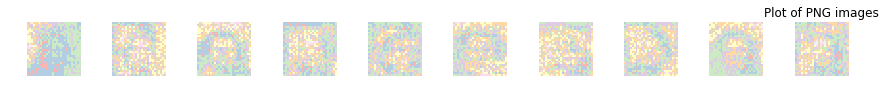

Time for epoch 120 is 0.03 min
G/D loss: [0.80665696, 0.0625] [0.6650584, 0.484375]
G/D loss: [0.7721487, 0.09375] [0.67769, 0.421875]
G/D loss: [0.74162817, 0.21875] [0.6693139, 0.359375]
G/D loss: [0.82260245, 0.0625] [0.6377108, 0.4375]
G/D loss: [0.7583643, 0.25] [0.6396977, 0.46875]
G/D loss: [0.9139747, 0.125] [0.6310805, 0.421875]
G/D loss: [0.9420893, 0.03125] [0.6655867, 0.34375]
G/D loss: [1.0605448, 0.03125] [0.67145693, 0.328125]
G/D loss: [0.67411983, 0.59375] [0.71546257, 0.078125]
G/D loss: [0.888314, 0.03125] [0.64687157, 0.46875]
G/D loss: [0.91737014, 0.09375] [0.65239334, 0.484375]
G/D loss: [0.92681235, 0.0625] [0.6423955, 0.4375]
G/D loss: [0.95723236, 0.0625] [0.6620466, 0.453125]
G/D loss: [0.8907125, 0.03125] [0.6778935, 0.4375]
G/D loss: [0.94493175, 0.03125] [0.67306, 0.421875]
G/D loss: [0.91397405, 0.09375] [0.6731715, 0.421875]
G/D loss: [0.84187293, 0.1875] [0.6995242, 0.4375]
G/D loss: [0.8876398, 0.125] [0.7050629, 0.390625]
G/D loss: [0.89773375, 0.0625

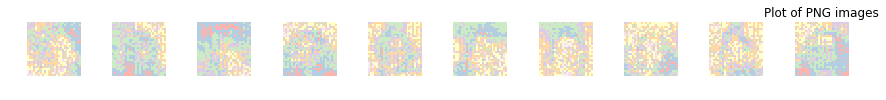

Time for epoch 150 is 0.02 min
G/D loss: [0.83125544, 0.0] [0.66955304, 0.390625]
G/D loss: [0.88285726, 0.0625] [0.69782317, 0.40625]
G/D loss: [0.8878063, 0.0] [0.6787895, 0.4375]
G/D loss: [0.8400388, 0.0625] [0.69330907, 0.4375]
G/D loss: [0.8228502, 0.0625] [0.67727697, 0.453125]
G/D loss: [0.79683024, 0.15625] [0.6840231, 0.390625]
G/D loss: [0.853428, 0.0625] [0.6882862, 0.421875]
G/D loss: [0.87749, 0.0625] [0.66861874, 0.46875]
G/D loss: [0.82195276, 0.1875] [0.6815567, 0.390625]
G/D loss: [0.8591294, 0.0] [0.67758703, 0.390625]
G/D loss: [0.8425189, 0.125] [0.6727828, 0.421875]
G/D loss: [0.7910226, 0.09375] [0.6789348, 0.484375]
G/D loss: [0.7551181, 0.25] [0.7197461, 0.40625]
G/D loss: [0.7810602, 0.15625] [0.71998477, 0.40625]
G/D loss: [0.8287163, 0.03125] [0.67587197, 0.46875]
G/D loss: [0.8138479, 0.0625] [0.6853824, 0.46875]
G/D loss: [0.9088763, 0.0] [0.6566102, 0.453125]
G/D loss: [0.7794479, 0.09375] [0.6810055, 0.46875]
G/D loss: [0.75302064, 0.21875] [0.6707038, 0

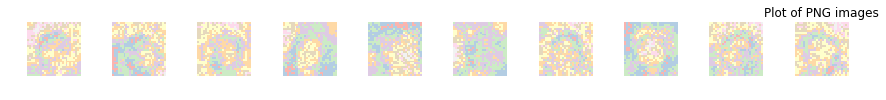

Time for epoch 180 is 0.02 min
G/D loss: [0.75602067, 0.1875] [0.676726, 0.453125]
G/D loss: [0.7729745, 0.25] [0.6812527, 0.453125]
G/D loss: [0.75275654, 0.15625] [0.6807784, 0.4375]
G/D loss: [0.7690347, 0.125] [0.70179665, 0.40625]
G/D loss: [0.78303784, 0.28125] [0.6841822, 0.4375]
G/D loss: [0.78962076, 0.15625] [0.68004143, 0.40625]
G/D loss: [0.8211894, 0.1875] [0.67500305, 0.4375]
G/D loss: [0.8515696, 0.09375] [0.6864711, 0.421875]
G/D loss: [0.8576394, 0.09375] [0.69952106, 0.4375]
G/D loss: [0.8263376, 0.09375] [0.6656295, 0.46875]
G/D loss: [0.8097618, 0.125] [0.65492886, 0.5]
G/D loss: [0.8339014, 0.03125] [0.67592674, 0.46875]
G/D loss: [0.8299043, 0.09375] [0.6689364, 0.453125]
G/D loss: [0.87209857, 0.125] [0.68397814, 0.46875]
G/D loss: [0.89312774, 0.0] [0.6765088, 0.5]
G/D loss: [0.84799373, 0.09375] [0.66690165, 0.5]
G/D loss: [0.79672724, 0.0625] [0.69055057, 0.4375]
G/D loss: [0.78199816, 0.0625] [0.68243563, 0.453125]
G/D loss: [0.7465002, 0.1875] [0.6732651, 0.

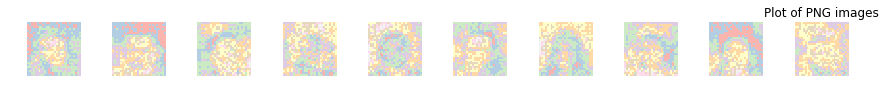

Time for epoch 210 is 0.03 min
G/D loss: [0.8427153, 0.1875] [0.70835364, 0.328125]
G/D loss: [0.8061506, 0.1875] [0.6722389, 0.484375]
G/D loss: [0.849959, 0.0625] [0.67020786, 0.40625]
G/D loss: [0.81877786, 0.09375] [0.6750574, 0.46875]
G/D loss: [0.81798077, 0.25] [0.69991475, 0.46875]
G/D loss: [0.886495, 0.0625] [0.6766068, 0.453125]
G/D loss: [0.8561795, 0.0625] [0.69120264, 0.453125]
G/D loss: [0.8434907, 0.09375] [0.6700989, 0.390625]
G/D loss: [0.8857559, 0.125] [0.65667796, 0.46875]
G/D loss: [0.78510064, 0.1875] [0.6652807, 0.453125]
G/D loss: [0.7746986, 0.3125] [0.6864419, 0.390625]
G/D loss: [0.78089666, 0.09375] [0.7069024, 0.390625]
G/D loss: [0.81187, 0.15625] [0.69273984, 0.453125]
G/D loss: [0.8279815, 0.09375] [0.67010254, 0.484375]
G/D loss: [0.8849031, 0.0] [0.6731678, 0.4375]
G/D loss: [0.9180553, 0.03125] [0.65897095, 0.5]
G/D loss: [0.7881068, 0.125] [0.6660641, 0.390625]
G/D loss: [0.8570158, 0.0] [0.6758441, 0.4375]
G/D loss: [0.8675308, 0.0625] [0.6654576, 

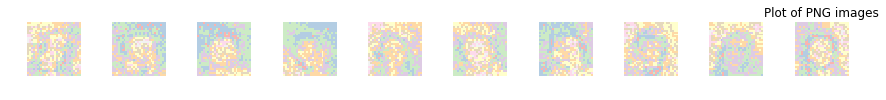

Time for epoch 240 is 0.02 min
G/D loss: [0.8512229, 0.03125] [0.66309893, 0.484375]
G/D loss: [0.8373214, 0.0625] [0.6922432, 0.46875]
G/D loss: [0.8399027, 0.0625] [0.67240477, 0.453125]
G/D loss: [0.8558105, 0.09375] [0.66435957, 0.4375]
G/D loss: [0.802672, 0.09375] [0.6731038, 0.46875]
G/D loss: [0.8027704, 0.1875] [0.6761849, 0.40625]
G/D loss: [0.7742672, 0.3125] [0.6748853, 0.4375]
G/D loss: [0.8326419, 0.15625] [0.6732787, 0.4375]
G/D loss: [0.8194752, 0.21875] [0.6737381, 0.484375]
G/D loss: [0.7549257, 0.3125] [0.6686737, 0.390625]
G/D loss: [0.8893901, 0.09375] [0.682823, 0.4375]
G/D loss: [0.8494605, 0.1875] [0.6933794, 0.5]
G/D loss: [0.9069483, 0.09375] [0.6670909, 0.4375]
G/D loss: [0.8729328, 0.03125] [0.684731, 0.390625]
G/D loss: [0.81523776, 0.1875] [0.6680081, 0.453125]
G/D loss: [0.9075292, 0.03125] [0.6450628, 0.484375]
G/D loss: [0.8787462, 0.0] [0.6646656, 0.4375]
G/D loss: [0.92994356, 0.0625] [0.6538472, 0.453125]
G/D loss: [0.8863919, 0.125] [0.6588104, 0.42

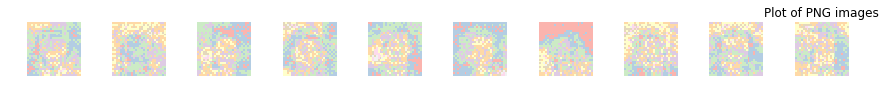

Time for epoch 270 is 0.02 min
G/D loss: [0.8335912, 0.375] [0.6710173, 0.4375]
G/D loss: [0.80937266, 0.28125] [0.6995735, 0.3125]
G/D loss: [0.87313545, 0.15625] [0.718715, 0.390625]
G/D loss: [1.0203757, 0.03125] [0.6838665, 0.421875]
G/D loss: [0.84580106, 0.1875] [0.6534301, 0.453125]
G/D loss: [0.82447374, 0.15625] [0.67443335, 0.4375]
G/D loss: [0.8783026, 0.0] [0.6897705, 0.421875]
G/D loss: [0.834998, 0.1875] [0.67188513, 0.453125]
G/D loss: [0.93791187, 0.15625] [0.68292964, 0.4375]
G/D loss: [0.8888072, 0.03125] [0.66478395, 0.421875]
G/D loss: [0.8782679, 0.0] [0.6595292, 0.484375]
G/D loss: [0.840078, 0.09375] [0.68800807, 0.453125]
G/D loss: [0.87770045, 0.03125] [0.65170956, 0.453125]
G/D loss: [0.8748933, 0.03125] [0.67586213, 0.46875]
G/D loss: [0.8201293, 0.09375] [0.669369, 0.421875]
G/D loss: [0.9074483, 0.0625] [0.6638206, 0.453125]
G/D loss: [0.9103626, 0.0625] [0.662682, 0.4375]
G/D loss: [0.8647896, 0.09375] [0.6797351, 0.46875]
G/D loss: [0.8473121, 0.125] [0.6

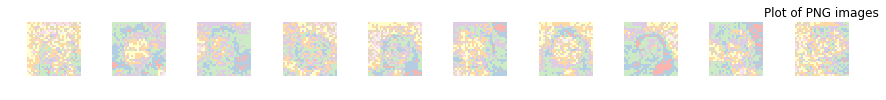

Time for epoch 300 is 0.02 min



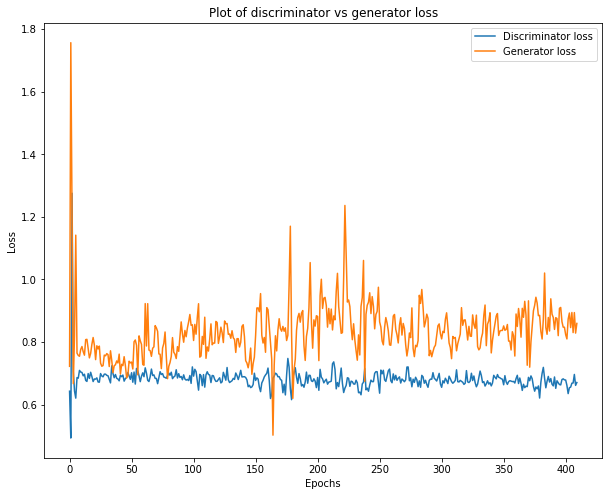

CPU times: user 13min 33s, sys: 7.29 s, total: 13min 40s
Wall time: 4min 30s


In [54]:
%%time    ############ TRAINING #################
train(epochs=400, plt_frq=30, BATCH_SIZE=batch_size_gan)

Epochs: 50
Batch size: 32
Batches per epoch: 3


G/D loss: [1.6111196, 0.0625] [0.46778914, 0.484375]


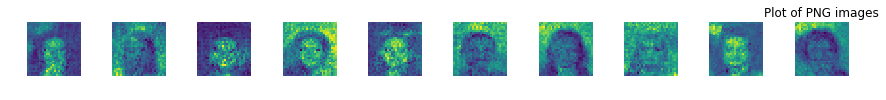

Time for epoch 1 is 0.03 min
G/D loss: [1.3920944, 0.15625] [0.480247, 0.46875]
G/D loss: [1.8335859, 0.03125] [0.4028641, 0.46875]
G/D loss: [1.3782599, 0.03125] [0.40245116, 0.484375]
G/D loss: [1.5934899, 0.09375] [0.48072824, 0.484375]
G/D loss: [1.3857527, 0.09375] [0.48946846, 0.484375]
G/D loss: [1.766762, 0.09375] [0.42504764, 0.5]
G/D loss: [1.6027966, 0.0] [0.4919567, 0.4375]
G/D loss: [1.4286757, 0.1875] [0.45212144, 0.5]
G/D loss: [1.6652473, 0.0625] [0.44605803, 0.484375]
G/D loss: [1.7229807, 0.03125] [0.50664127, 0.421875]
G/D loss: [2.0194225, 0.03125] [0.48031595, 0.4375]
G/D loss: [1.7160702, 0.0625] [0.46935987, 0.40625]
G/D loss: [1.4470342, 0.03125] [0.45902032, 0.46875]
G/D loss: [1.4865153, 0.125] [0.43600327, 0.421875]
G/D loss: [1.5842295, 0.0625] [0.41935807, 0.484375]
G/D loss: [1.4666946, 0.0625] [0.45354047, 0.484375]
G/D loss: [1.5837183, 0.125] [0.53018194, 0.4375]
G/D loss: [1.6276407, 0.0625] [0.39526588, 0.5]
G/D loss: [1.9982746, 0.0625] [0.46725783, 

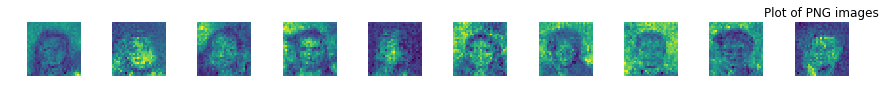

Time for epoch 30 is 0.02 min
G/D loss: [1.6630116, 0.0625] [0.39701468, 0.46875]
G/D loss: [1.9761614, 0.0] [0.5360121, 0.40625]
G/D loss: [1.7605989, 0.09375] [0.4818142, 0.390625]
G/D loss: [1.620336, 0.0625] [0.44217664, 0.484375]
G/D loss: [1.6248283, 0.0625] [0.4189898, 0.5]
G/D loss: [1.6581208, 0.09375] [0.39576963, 0.46875]
G/D loss: [1.674587, 0.09375] [0.42477554, 0.453125]
G/D loss: [1.6945521, 0.0] [0.37111866, 0.46875]
G/D loss: [1.3861896, 0.0625] [0.43742067, 0.46875]
G/D loss: [1.6342454, 0.0625] [0.41817692, 0.46875]
G/D loss: [1.8255006, 0.125] [0.42585915, 0.453125]
G/D loss: [2.1290298, 0.09375] [0.39977038, 0.484375]
G/D loss: [1.5359004, 0.09375] [0.40054655, 0.46875]
G/D loss: [1.5896308, 0.15625] [0.4156024, 0.46875]
G/D loss: [1.642056, 0.09375] [0.4847991, 0.484375]
G/D loss: [1.3727612, 0.15625] [0.38328347, 0.5]
G/D loss: [1.5807996, 0.125] [0.48364335, 0.484375]
G/D loss: [1.8741823, 0.0] [0.4106657, 0.421875]
G/D loss: [1.6989539, 0.09375] [0.43188053, 0.

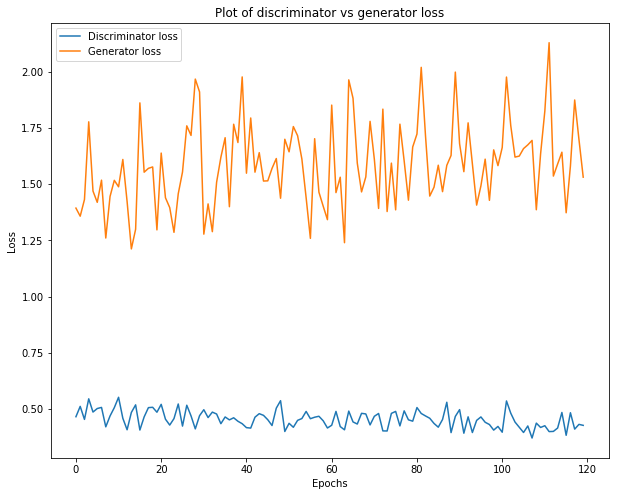

CPU times: user 2min 15s, sys: 1.31 s, total: 2min 17s
Wall time: 45.3 s


In [68]:
%%time   ########## TRAINING ###############
train(epochs=120, plt_frq=30, BATCH_SIZE=batch_size_gan) 

**Solution to 1.C.3**

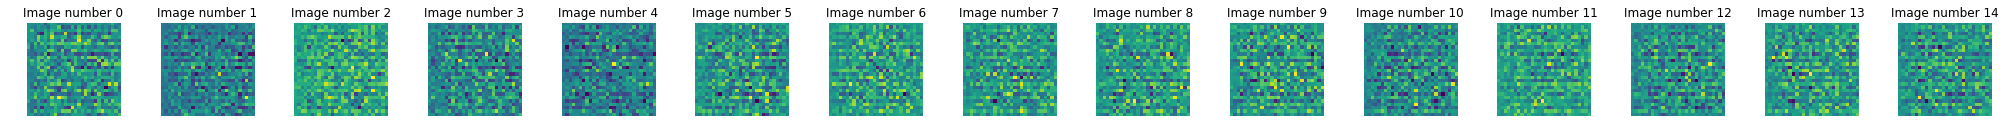

In [43]:
# def plot_generated(e, n_ex=10, dim=(1, 10), figsize=(12, 2)):
def generated_15_images():
    n_ex = 15
    dim=(1, 15)
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.astype('float32')/255
    
    plt.figure(figsize=(28, 28))
    for i in range(dim[1]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 2], interpolation='nearest')
        plt.axis('off')
        plt.title('Image number {}'.format(i), fontsize=12)
    plt.tight_layout()
#     plt.suptitle("15 Generated Images form GAN")
    plt.savefig('GAN_output_images_gif/Image_number_{:04d}.png'.format(i+1))
    plt.show()

generated_15_images()

**How do the generated faces compare in quality to celebrity faces from the training samples? 
How do they compare in quality to the faces generated via VAE?**

VAE images predicted had a better quality for fewer epoch trains.
15 Images generated look similar to the images generated in the intermediate epochs during training of GAN model.

In [114]:
#############  Some lessons learnt during training of the GAN and VAE model ##################

# Reduced input image size (real images). Rational for smaller image size in GAN: if the img size is large, 
# it will be too difficult for the generator to create a very realistic image that fools the discriminator. 
# In such a case, the discriminator is too good while the generator is too bad, and the latter won't be able to catch up 
# with the former (given our limited computational resources and time)

# added leakyRelu as a separate layer in the model rather than using it in the Conv or Dense layers as it helps to save the model
# using model.save() This acts as a checkpoint

# increased nodes in each layer

# used mini batch sizes of 32

# changed kernel size to 5*5 from 3*3  for discriminator and generator  and used strides which helped train faster

# changed filters to larger size and reduced layers

# by literature and by training the model for few epochs learnt that a lower learning rate with Adam optimizer
# is best suited for GAN model

# Addded batch normalization in generator in discriminator

# total param is 1.2M in the GAN model

# Conv2DTranspose layers in GAN model has the same behaviour as the UpSampling layer used in the VAE model

# Personally for me, VAE was much harder to train and took longer duration than the GAN model,
# not sure if the computation power and jupyter hub load was the real reason.

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN 

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN 

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs